In [1]:
import warnings
warnings.filterwarnings("ignore")

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# From ArcFace to SimpleFace

*Jun 12, 2023*

---------------------------------------------------

Once, while working on a face swapping project I was using [ArcFace](https://arxiv.org/abs/1801.07698) as an identity estimator. The key problem with face swapping is finding the trade-off between identity information (face shape) and attributes like pose, expression, illumination etc. and the resulting quality depends a lot on the quality of the pre-trained identity estimator. So I was naturally looking into ways to improve ours. I wanted to clean identity embeddings of all the irrelevant attribute information, which means a tighter intra-class grouping. So I was looking at the loss and thinking and this is what came out.

# ArcFace Primer

ArcFace is still a workhorse in many face-related AI applications despite its respectable age due to availability and decent quality of pretrained models. It came as an improvement to a whole line of angular margin face recognition models like SphereFace and CosineFace. It formulates the task of face recognition not as a metric learning problem, but as a classification task with target classes being face identities and a specially designed loss function. It consists of a linear layer with some trickery. 

The ArcFace loss is parameterized by a weight matrix $W$ of *"anchor"* vectors for each identity/class. This weight matrix is multiplied by an embedding vector $x$. From school we know that:

$$ W_i^T x_j = \|W_i\| \|x_j\| \cos(\theta_i) $$

where $\theta_i$ is the angle between vectors $W_i$ and $x_j$. It was shown many times that optimizing for this dot product directly is inefficient as inter-class separation gets worse and a lot of irrelevant noise and variance leak from the data into embeddings. Putting face embeddings on a hypersphere and optimizing for an angle between vectors is a better strategy. Getting the angle is easy:

$$ \theta_i = \arccos \left( \frac{W_i^T x_j}{ \|W_i\| \|x_j\|} \right) $$

What ArcFace proposes is to add a constant margin $m$ to the angle between the class sample and its corresponding anchor vector precisely to enforce clearer inter-class separation. That's it. The rest of the loss function is plain old softmax with the cross-entropy:

$$ L = - \log \frac{e^{ s \cos \left( \theta_{y_i} + m \right)}}{e^{ s \cos \left( \theta_{y_i} + m \right)} + \sum_{j\neq y_i} e^{ s \cos \left( \theta_j\right)}} $$

Here $s$ is a scaling factor which plays the role of the softmax temperature, essentially, and $y_i$ is the *index* of the target class. Seems simple and intuitive enough, but can we make it even simpler?

# Stripped to the Bone

While reviewing ArcFace paper I zoomed into a softmax logits plot (Fig. 4b):

```{image} assets/from_arcface_to_simpleface/logits_cut.png
:alt: logits-cut
:width: 520px
:height: 400px
:align: center
```

And I have so many questions about it! Like, what's this? What is the point of this graph? These are just some squiggly lines. What is the reader supposed to make from them? Why do they only show us the interval between 20 and 100 degrees? What about angles below 20 and above 100 degrees? 

This useless piece of visual noise exists for the sole purpose of being there. So here's a bit blurry but full plot which I found in this [nice article](https://laniakea2018.wordpress.com/2018/06/16/lecture-9-arcface-additive-angular-margin-loss-for-deep-face-recognition/):

```{image} assets/from_arcface_to_simpleface/logits_full.png
:alt: logits-full
:width: 520px
:height: 400px
:align: center
```

Now this is how you do plots! We can now see the full range of angles and immediately make some observations.

**Observation 1.** *All* of these functions have critical points somewhere besides the actual optimum. This may not be a big deal, but it is kinda bad taste, IMHO. A proper well-behaved loss function should have one and only critical point - at the optimum and have a good reason for every single extra one. 

**Observation 2.** ArcFace logits aren't even monotonic. They have a local optimum at 180 degrees. This can make somebody have a really bad day, I'd say.

**Observation 3.** ArcFace logits are the only function which has *non-zero* slope at 0 degrees. Now that's interesting.

In practice they add some corrections to ArcFace (so-called *easy* margin and *hard* margin) which change the shape of the "tail" of the logits but they don't get rid of the abovementioned problems.

Let's think of the ArcFace a bit. The graph of the logits doesn't have a continuation to the left because the dot product gives you the angle along the shortest arc which is always between 0 and $\pi$. This means that a non-zero derivative of logits at 0 produces non-zero updates to both $W_i$ and $x_j$ no matter how close they are. Compare this to Softmax logits, for example, which have a zero-derivative at 0 degrees and gradient updates gradually die out when vectors get close. Softmax here is like $L_2$-distance and ArcFace is like $L_1$-distance, but on a sphere. This explains why plain softmax creates embeddings with blurry inter-class boundaries while ArcFace manages to achieve sharp separation. 

For the same reason the term *"margin"* cannot be really applied to the $m$ parameter of the ArcFace loss. It could be called a margin if there were negative angles available. In that case logits could go past zero and then converge at an angle $\theta = -m$ thus creating a *margin*. But angles are clipped at zero, and when the logit goes beyond it, the direction of the trajectory is just flipped back, so it constantly jiggles around zero. 

> From this perspective we can see that CosineFace is completely useless, as the only thing it does is adds a constant to a dot product, which does not have *any* impact on the gradients flowing through the logits, just adds a constant scaling factor. Like, literally. Here's CosFace loss:
>
> $$ L = - \log \frac{e^{ s \left( \cos \left( \theta_{y_i} \right) - m \right)}}{e^{ s \left( \cos \left( \theta_{y_i} \right) - m \right)} + \sum_{j\neq y_i} e^{ s \cos \left( \theta_j\right)}} 
    = - \log e^{-sm} \frac{e^{ s \cos \left( \theta_{y_i} \right)}}{ e^{-sm} e^{s \cos \left( \theta_{y_i} \right)} + \sum_{j\neq y_i} e^{ s \cos \left( \theta_j\right)}} $$
>    
> which for all intents and purposes is:
>
> $$ L = - \log \frac{e^{ s \cos \left( \theta_{y_i} \right)}}{ C e^{s \cos \left( \theta_{y_i} \right)} + \sum_{j\neq y_i} e^{ s \cos \left( \theta_j\right)}} $$
>
> The softmax sum is taken over all the classes, and re-weighting a single of thousands terms should ring a bell that something's not right here. It could make a bit more sense if a margin $m$ was dependent on the number of classes, so its effect is preserved, but they actually address this issue in the [paper](https://arxiv.org/pdf/1801.09414.pdf) and say that bigger margin reduces training stability (big surprise!). Let's note, however, that this logic is not applicable to ArcFace, as angular margin changes gradients non-linearly due to the presence of an arccos function. But I digress.

Where was I? Ah, ArcFace doesn't have a zero gradient at zero. And you know, which logit function also doesn't have zero gradient at zero? Angle function. Here it is in all its glory:

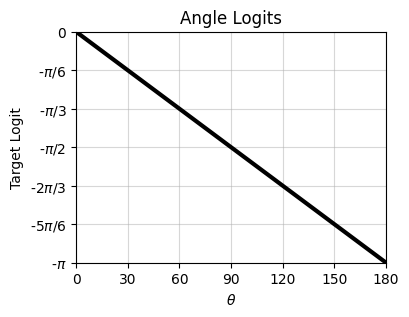

In [2]:
plt.figure(figsize = (4,3))
plt.title("Angle Logits")
plt.plot(np.rad2deg(np.linspace(0, np.pi)), -np.linspace(0, np.pi), 'k-', lw = 3)
plt.xticks(np.arange(0, 181, 30))
plt.yticks(np.linspace(-np.pi, 0, 7), ["-$\pi$", "-$5\pi/6$", "-$2\pi/3$", "-$\pi/2$", "-$\pi/3$", "-$\pi/6$", 0])
plt.ylabel("Target Logit")
plt.xlabel("$\\theta$")
plt.xlim(0, 180)
plt.ylim(-np.pi, 0)
plt.grid(alpha = 0.5)

It has several advantages:
1. It does not have any shady local minima
2. It does not have any critical points whatsoever
3. It has constant derivative everywhere, as well as at zero
4. It is almost 3x more computationally efficient
5. Intuitively it makes much more sense, as we're directly optimizing for the angle between vectors

The final loss function with angular logits would be:

$$ L = - \log \frac{e^{ -s \theta_{y_i}}}{ \sum_j e^{ -s \theta_j }} $$

where $\theta_i = \arccos \left( \dfrac{W_i^T x_j}{\|W_i\| \|x_j\|} \right)$. Note that we now don't need to apply any margins selectively as in ArcFace, CosFace or whatever. I'd call this loss a SimpleFace. 

# Experiments

To verify that angular logits achieve the same so-called "large margin" separation I've ran the same toy experiment they use in papers. I took 10 identities with the most images from the LFW dataset, sampled 50 photos from each identity totalling at 500 RGB image 128x128. I then took an ImageNet-pretrained ResNet18 and fine-tuned it on these 500 images using ArcFace and SimpleFace. Training both models using a 2D feature actually was pretty tricky. In such low dimensions some corner cases arise which you generally wouldn't care about with embedding dimension of 512. One such corner case is appearance of local minima in the gaps between $W_i$ vectors. Let me illustrate:

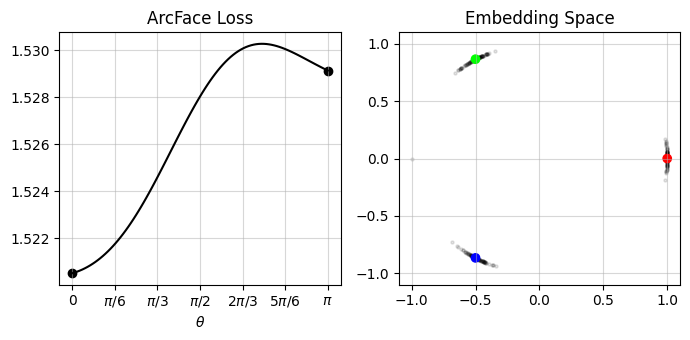

In [3]:
import torch
import torch.nn.functional as ptf

class AngularLoss(torch.nn.Module):
    
    def __init__(self, dimension, num_identities, logits):
        super().__init__()
        self.dimension = dimension
        self.num_identities = num_identities
        self.logits = logits
        self.weight = torch.nn.Parameter(torch.randn(num_identities, dimension))
        
    def forward(self, embeddings, targets, margin = 0.5, scale = 1, eps = 1e-7):
        embeddings = ptf.normalize(embeddings, p = 2, dim = 1)
        weights = ptf.normalize(self.weight, p = 2, dim = 1)
        cosine = ptf.linear(embeddings, weights).clamp(-1 + eps, 1 - eps)

        one_hot_targets = torch.zeros_like(cosine)
        one_hot_targets.scatter_(1, targets.view(-1, 1).long(), 1)
        
        angles = torch.acos(cosine)
        if self.logits == "arcface":
            marginal_cosine = torch.cos(angles + margin)
            logits = cosine * (1 - one_hot_targets) + marginal_cosine * one_hot_targets
        elif self.logits == "simpleface":
            logits = -angles
        else:
            raise Exception("Unknown loss type")
        
        probs = ptf.softmax(scale*logits, dim = 1)
        loss = ptf.binary_cross_entropy(probs, one_hot_targets) * self.num_identities
        return loss

loss = AngularLoss(dimension = 2, num_identities = 3, logits = 'arcface').cpu()
loss.weight.data = torch.tensor([[1, 0], [-0.5, 0.866], [-0.5, -0.866]])
phi = 2*np.pi / 3 * torch.tensor([0, -1.0, 1.0])
data = torch.stack([torch.cos(phi), torch.sin(phi)]).T.cpu()
data = data.repeat_interleave(100, dim = 0)
data = data + 0.07*torch.randn_like(data)
data = ptf.normalize(data, dim = 1)

z = []
t = np.linspace(0, np.pi, 101)
for theta in t:
    data[0, 0] = torch.cos(phi[0] + theta)
    data[0, 1] = torch.sin(phi[0] + theta)
    y = loss(data, torch.arange(3), scale = 1)
    z.append(float(y))

plt.figure(figsize = (7, 3.5))
plt.subplot(1,2,1)
plt.title('ArcFace Loss')
plt.plot(t, z, 'k-')
plt.xlabel("$\\theta$")
plt.xticks(np.linspace(np.pi, 0, 7), ["$\pi$", "$5\pi/6$", "$2\pi/3$", "$\pi/2$", "$\pi/3$", "$\pi/6$", 0])
plt.scatter([0, np.pi], [z[0], z[-1]], color = 'black')
plt.grid(alpha = 0.5)

plt.subplot(1,2,2)
plt.title("Embedding Space")
plt.scatter(data[:,0], data[:,1], color = 'black', alpha = 0.1, s = 5)
plt.scatter(loss.weight.data[:,0], loss.weight.data[:,1], c = ['red', 'lime', 'blue'])
plt.grid(alpha = 0.5)
plt.xticks([-1, -0.5, 0, 0.5, 1])
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

plt.tight_layout()

Left plot shows how the loss function depends on a single sample. Because softmax creates both attractive and repulsive "forces" between intra- and inter-class samples, there's a possibility to have a point of equilibrium when repulsive forces balance each other in the gaps due to symmetry. Depending on the data, this can cause two $W_i$ vectors to collapse into one of such local minima if repulsion from the neighbors is stronger than between these two vectors. What really sucks is that this problem occurs near when weight vectors are distributed uniformly, which happens at near the optimum, when everything is almost settled. This problem goes away in higher dimensions, however, where there are much more symmetries which should align to balance everything just right. Actually in 3D already this problem practically goes away.

The angular margin demonstrates the same tight clustering in these toy experiments as ArcFace. At lower dimensions it converges slightly faster, but speed of convergence evens out at higher dimensions, as random vectors are mostly perpendicular there and don't fall into problem regions in the tail of ArcFace logits:

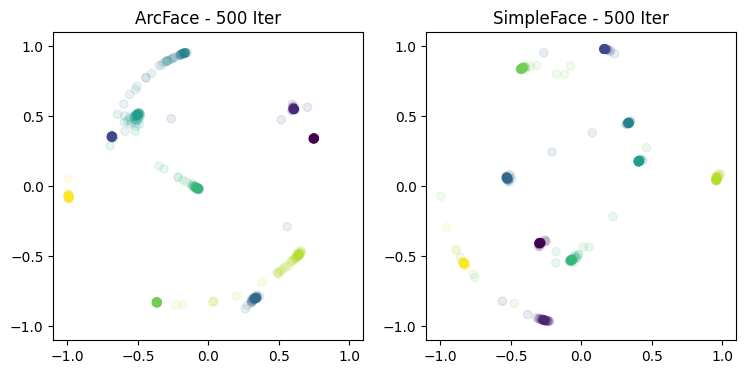

In [4]:
image1 = Image.open("assets/from_arcface_to_simpleface/arcface_clusters.png")
image2 = Image.open("assets/from_arcface_to_simpleface/simpleface_clusters.png")

new_image = Image.new("RGB", (image1.width + image2.width, image1.height))
new_image.paste(image1, (0, 0))
new_image.paste(image2, (image1.width, 0))
new_image

# Conclusion

Today we’ve taken apart a widely used ArcFace loss function and created a simpler and clearer version of it which directly optimizes for angles between vectors instead of cosines with margins. This new loss function improves on desirable properties of ArcFace and fixes some of its flaws (local minima, saddle points, breaks, computational cost). It demonstrates similar performance in small-scale tests, but proper full-scale training should still be done to compare the two. I expect there to be no significant difference in the results except, maybe, for convergence speed. And in general it is easier to explain, understand and implement. 

And if you ask me, if this did help with the face swapper and identity-attribute disentanglement - no, it didn't. Have a good night.

In [5]:
import random
from tqdm import tqdm
from pathlib import Path
from itertools import groupby, chain

from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.transforms import ToTensor, Normalize, Compose


random.seed(42)
N_CLASSES = 10
BATCH_SIZE = 32
CLASS_SIZE = 50
DATA_SIZE = CLASS_SIZE * N_CLASSES


class FaceDataset(Dataset):
    
    def __init__(self, lfw_dir, eps = 1e-3):
        datadir = Path(lfw_dir)
        images = sorted(list(datadir.glob("*/*.jpg")))
        identities = groupby(images, key = lambda p: p.parent.name)
        identities = map(lambda g: list(g[1]), identities)
        identities = filter(lambda g: len(g) > 52, identities)
        identities = list(identities)
        identities = [random.sample(idt, CLASS_SIZE) for idt in identities[:N_CLASSES]]
        
        self.identities = sorted(chain(*identities))
        self.targets = torch.repeat_interleave(torch.arange(N_CLASSES), CLASS_SIZE)
        
        self.transform = Compose([
            ToTensor(),
            Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])

    def __len__(self):
        return 2**32 - 1

    def __getitem__(self, idx):
        path = self.identities[idx]
        target = self.targets[idx]
        crop = 40
        size = 128
        image = Image.open(path).crop([crop, crop, 250 - crop, 250 - crop]).resize((size, size), Image.Resampling.BICUBIC)
        image = self.transform(image)
        return image, target
    
    
class Model(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = models.resnet18(weights = models.ResNet18_Weights.DEFAULT)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = torch.nn.Identity()
        self.classifier = torch.nn.Linear(in_features, num_classes, bias = True)
        torch.nn.init.kaiming_normal_(self.classifier.weight)
        torch.nn.init.normal_(self.classifier.bias, std = 0.01)

    def forward(self, x):
        features = self.backbone(x)
        embedding = self.classifier(features)
        return embedding


EMB_DIM = 3
dataset = FaceDataset('../datasets/lfw/lfw_funneled/')
backbone = Model(num_classes = EMB_DIM).cuda().train().requires_grad_(True)
loss = AngularLoss(EMB_DIM, N_CLASSES, logits = "simpleface").cuda().train().requires_grad_(True)
opt = torch.optim.Adam(list(backbone.parameters()) + list(loss.parameters()), lr = 1e-3)

N_STEPS = 500
pbar = tqdm(range(N_STEPS))
for step in pbar:
    x, y = zip(*[dataset[i] for i in np.random.randint(0, DATA_SIZE, BATCH_SIZE)])
    images = torch.stack(x).cuda()
    targets = torch.stack(y).cuda()
    embedding = backbone(images)
    ce = loss(embedding, targets, scale = 1)
    
    opt.zero_grad()
    ce.backward()
    opt.step()
    
    pbar.set_description(f"Loss: {float(ce.detach().cpu()):.6f}")

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

Loss: 3.261861:   0%|                                                                          | 0/500 [00:05<?, ?it/s]

Loss: 3.261861:   0%|▏                                                                 | 1/500 [00:05<42:33,  5.12s/it]

Loss: 3.151331:   0%|▏                                                                 | 1/500 [00:05<42:33,  5.12s/it]

Loss: 3.151331:   0%|▎                                                                 | 2/500 [00:05<18:04,  2.18s/it]

Loss: 3.026774:   0%|▎                                                                 | 2/500 [00:05<18:04,  2.18s/it]

Loss: 3.026774:   1%|▍                                                                 | 3/500 [00:05<10:11,  1.23s/it]

Loss: 2.843414:   1%|▍                                                                 | 3/500 [00:05<10:11,  1.23s/it]

Loss: 2.843414:   1%|▌                                                                 | 4/500 [00:05<06:30,  1.27it/s]

Loss: 2.802232:   1%|▌                                                                 | 4/500 [00:05<06:30,  1.27it/s]

Loss: 2.656396:   1%|▌                                                                 | 4/500 [00:05<06:30,  1.27it/s]

Loss: 2.656396:   1%|▊                                                                 | 6/500 [00:05<03:30,  2.35it/s]

Loss: 2.652083:   1%|▊                                                                 | 6/500 [00:05<03:30,  2.35it/s]

Loss: 2.652083:   1%|▉                                                                 | 7/500 [00:05<02:47,  2.95it/s]

Loss: 2.731946:   1%|▉                                                                 | 7/500 [00:05<02:47,  2.95it/s]

Loss: 2.731946:   2%|█                                                                 | 8/500 [00:05<02:16,  3.59it/s]

Loss: 2.700913:   2%|█                                                                 | 8/500 [00:05<02:16,  3.59it/s]

Loss: 2.700913:   2%|█▏                                                                | 9/500 [00:05<01:52,  4.38it/s]

Loss: 2.828818:   2%|█▏                                                                | 9/500 [00:06<01:52,  4.38it/s]

Loss: 2.535447:   2%|█▏                                                                | 9/500 [00:06<01:52,  4.38it/s]

Loss: 2.535447:   2%|█▍                                                               | 11/500 [00:06<01:24,  5.75it/s]

Loss: 2.456300:   2%|█▍                                                               | 11/500 [00:06<01:24,  5.75it/s]

Loss: 2.632555:   2%|█▍                                                               | 11/500 [00:06<01:24,  5.75it/s]

Loss: 2.632555:   3%|█▋                                                               | 13/500 [00:06<01:10,  6.87it/s]

Loss: 2.471443:   3%|█▋                                                               | 13/500 [00:06<01:10,  6.87it/s]

Loss: 2.554898:   3%|█▋                                                               | 13/500 [00:06<01:10,  6.87it/s]

Loss: 2.554898:   3%|█▉                                                               | 15/500 [00:06<01:02,  7.80it/s]

Loss: 2.489085:   3%|█▉                                                               | 15/500 [00:06<01:02,  7.80it/s]

Loss: 2.483389:   3%|█▉                                                               | 15/500 [00:06<01:02,  7.80it/s]

Loss: 2.483389:   3%|██▏                                                              | 17/500 [00:06<00:56,  8.55it/s]

Loss: 2.467150:   3%|██▏                                                              | 17/500 [00:06<00:56,  8.55it/s]

Loss: 2.366472:   3%|██▏                                                              | 17/500 [00:06<00:56,  8.55it/s]

Loss: 2.366472:   4%|██▍                                                              | 19/500 [00:06<00:53,  9.07it/s]

Loss: 2.338296:   4%|██▍                                                              | 19/500 [00:07<00:53,  9.07it/s]

Loss: 2.492689:   4%|██▍                                                              | 19/500 [00:07<00:53,  9.07it/s]

Loss: 2.492689:   4%|██▋                                                              | 21/500 [00:07<00:52,  9.06it/s]

Loss: 2.429354:   4%|██▋                                                              | 21/500 [00:07<00:52,  9.06it/s]

Loss: 2.429354:   4%|██▊                                                              | 22/500 [00:07<00:52,  9.09it/s]

Loss: 2.401383:   4%|██▊                                                              | 22/500 [00:07<00:52,  9.09it/s]

Loss: 2.456308:   4%|██▊                                                              | 22/500 [00:07<00:52,  9.09it/s]

Loss: 2.456308:   5%|███                                                              | 24/500 [00:07<00:50,  9.45it/s]

Loss: 2.407374:   5%|███                                                              | 24/500 [00:07<00:50,  9.45it/s]

Loss: 2.407374:   5%|███▎                                                             | 25/500 [00:07<00:50,  9.36it/s]

Loss: 2.455986:   5%|███▎                                                             | 25/500 [00:07<00:50,  9.36it/s]

Loss: 2.455986:   5%|███▍                                                             | 26/500 [00:07<00:51,  9.27it/s]

Loss: 2.329022:   5%|███▍                                                             | 26/500 [00:07<00:51,  9.27it/s]

Loss: 2.362246:   5%|███▍                                                             | 26/500 [00:07<00:51,  9.27it/s]

Loss: 2.362246:   6%|███▋                                                             | 28/500 [00:07<00:49,  9.45it/s]

Loss: 2.249096:   6%|███▋                                                             | 28/500 [00:08<00:49,  9.45it/s]

Loss: 2.421732:   6%|███▋                                                             | 28/500 [00:08<00:49,  9.45it/s]

Loss: 2.421732:   6%|███▉                                                             | 30/500 [00:08<00:49,  9.54it/s]

Loss: 2.526928:   6%|███▉                                                             | 30/500 [00:08<00:49,  9.54it/s]

Loss: 2.526928:   6%|████                                                             | 31/500 [00:08<00:48,  9.61it/s]

Loss: 2.325398:   6%|████                                                             | 31/500 [00:08<00:48,  9.61it/s]

Loss: 2.325398:   6%|████▏                                                            | 32/500 [00:08<00:49,  9.45it/s]

Loss: 2.238376:   6%|████▏                                                            | 32/500 [00:08<00:49,  9.45it/s]

Loss: 2.238376:   7%|████▎                                                            | 33/500 [00:08<00:49,  9.52it/s]

Loss: 2.295043:   7%|████▎                                                            | 33/500 [00:08<00:49,  9.52it/s]

Loss: 2.295043:   7%|████▍                                                            | 34/500 [00:08<00:50,  9.26it/s]

Loss: 2.142849:   7%|████▍                                                            | 34/500 [00:08<00:50,  9.26it/s]

Loss: 2.142849:   7%|████▌                                                            | 35/500 [00:08<00:52,  8.90it/s]

Loss: 2.364918:   7%|████▌                                                            | 35/500 [00:08<00:52,  8.90it/s]

Loss: 2.364918:   7%|████▋                                                            | 36/500 [00:08<00:54,  8.52it/s]

Loss: 2.294923:   7%|████▋                                                            | 36/500 [00:08<00:54,  8.52it/s]

Loss: 2.294923:   7%|████▊                                                            | 37/500 [00:08<00:55,  8.33it/s]

Loss: 2.347764:   7%|████▊                                                            | 37/500 [00:09<00:55,  8.33it/s]

Loss: 2.347764:   8%|████▉                                                            | 38/500 [00:09<00:54,  8.41it/s]

Loss: 2.265432:   8%|████▉                                                            | 38/500 [00:09<00:54,  8.41it/s]

Loss: 2.265432:   8%|█████                                                            | 39/500 [00:09<00:54,  8.53it/s]

Loss: 2.141755:   8%|█████                                                            | 39/500 [00:09<00:54,  8.53it/s]

Loss: 2.141755:   8%|█████▏                                                           | 40/500 [00:09<00:52,  8.79it/s]

Loss: 2.437001:   8%|█████▏                                                           | 40/500 [00:09<00:52,  8.79it/s]

Loss: 2.437001:   8%|█████▎                                                           | 41/500 [00:09<00:53,  8.66it/s]

Loss: 2.212433:   8%|█████▎                                                           | 41/500 [00:09<00:53,  8.66it/s]

Loss: 2.212433:   8%|█████▍                                                           | 42/500 [00:09<00:51,  8.86it/s]

Loss: 2.191061:   8%|█████▍                                                           | 42/500 [00:09<00:51,  8.86it/s]

Loss: 2.191061:   9%|█████▌                                                           | 43/500 [00:09<00:49,  9.14it/s]

Loss: 2.169745:   9%|█████▌                                                           | 43/500 [00:09<00:49,  9.14it/s]

Loss: 2.169745:   9%|█████▋                                                           | 44/500 [00:09<00:48,  9.32it/s]

Loss: 2.214854:   9%|█████▋                                                           | 44/500 [00:09<00:48,  9.32it/s]

Loss: 2.214854:   9%|█████▊                                                           | 45/500 [00:09<00:49,  9.19it/s]

Loss: 2.152803:   9%|█████▊                                                           | 45/500 [00:09<00:49,  9.19it/s]

Loss: 2.152803:   9%|█████▉                                                           | 46/500 [00:09<00:50,  8.95it/s]

Loss: 2.155796:   9%|█████▉                                                           | 46/500 [00:10<00:50,  8.95it/s]

Loss: 2.155796:   9%|██████                                                           | 47/500 [00:10<00:52,  8.62it/s]

Loss: 2.167847:   9%|██████                                                           | 47/500 [00:10<00:52,  8.62it/s]

Loss: 2.167847:  10%|██████▏                                                          | 48/500 [00:10<00:51,  8.81it/s]

Loss: 2.129522:  10%|██████▏                                                          | 48/500 [00:10<00:51,  8.81it/s]

Loss: 2.129522:  10%|██████▎                                                          | 49/500 [00:10<00:50,  8.96it/s]

Loss: 2.223028:  10%|██████▎                                                          | 49/500 [00:10<00:50,  8.96it/s]

Loss: 2.223028:  10%|██████▌                                                          | 50/500 [00:10<00:49,  9.09it/s]

Loss: 2.111752:  10%|██████▌                                                          | 50/500 [00:10<00:49,  9.09it/s]

Loss: 2.111752:  10%|██████▋                                                          | 51/500 [00:10<00:48,  9.34it/s]

Loss: 2.181881:  10%|██████▋                                                          | 51/500 [00:10<00:48,  9.34it/s]

Loss: 2.181881:  10%|██████▊                                                          | 52/500 [00:10<00:48,  9.24it/s]

Loss: 2.115697:  10%|██████▊                                                          | 52/500 [00:10<00:48,  9.24it/s]

Loss: 2.101024:  10%|██████▊                                                          | 52/500 [00:10<00:48,  9.24it/s]

Loss: 2.101024:  11%|███████                                                          | 54/500 [00:10<00:45,  9.71it/s]

Loss: 2.116260:  11%|███████                                                          | 54/500 [00:10<00:45,  9.71it/s]

Loss: 2.221580:  11%|███████                                                          | 54/500 [00:11<00:45,  9.71it/s]

Loss: 2.221580:  11%|███████▎                                                         | 56/500 [00:11<00:45,  9.78it/s]

Loss: 2.101627:  11%|███████▎                                                         | 56/500 [00:11<00:45,  9.78it/s]

Loss: 2.163404:  11%|███████▎                                                         | 56/500 [00:11<00:45,  9.78it/s]

Loss: 2.163404:  12%|███████▌                                                         | 58/500 [00:11<00:44, 10.03it/s]

Loss: 2.103151:  12%|███████▌                                                         | 58/500 [00:11<00:44, 10.03it/s]

Loss: 2.098188:  12%|███████▌                                                         | 58/500 [00:11<00:44, 10.03it/s]

Loss: 2.098188:  12%|███████▊                                                         | 60/500 [00:11<00:43, 10.08it/s]

Loss: 2.233232:  12%|███████▊                                                         | 60/500 [00:11<00:43, 10.08it/s]

Loss: 2.061730:  12%|███████▊                                                         | 60/500 [00:11<00:43, 10.08it/s]

Loss: 2.061730:  12%|████████                                                         | 62/500 [00:11<00:42, 10.36it/s]

Loss: 2.147539:  12%|████████                                                         | 62/500 [00:11<00:42, 10.36it/s]

Loss: 2.061215:  12%|████████                                                         | 62/500 [00:11<00:42, 10.36it/s]

Loss: 2.061215:  13%|████████▎                                                        | 64/500 [00:11<00:41, 10.58it/s]

Loss: 2.077138:  13%|████████▎                                                        | 64/500 [00:11<00:41, 10.58it/s]

Loss: 2.084794:  13%|████████▎                                                        | 64/500 [00:11<00:41, 10.58it/s]

Loss: 2.084794:  13%|████████▌                                                        | 66/500 [00:11<00:41, 10.39it/s]

Loss: 2.045146:  13%|████████▌                                                        | 66/500 [00:12<00:41, 10.39it/s]

Loss: 2.075148:  13%|████████▌                                                        | 66/500 [00:12<00:41, 10.39it/s]

Loss: 2.075148:  14%|████████▊                                                        | 68/500 [00:12<00:41, 10.48it/s]

Loss: 2.034855:  14%|████████▊                                                        | 68/500 [00:12<00:41, 10.48it/s]

Loss: 2.107277:  14%|████████▊                                                        | 68/500 [00:12<00:41, 10.48it/s]

Loss: 2.107277:  14%|█████████                                                        | 70/500 [00:12<00:40, 10.56it/s]

Loss: 2.055995:  14%|█████████                                                        | 70/500 [00:12<00:40, 10.56it/s]

Loss: 2.077784:  14%|█████████                                                        | 70/500 [00:12<00:40, 10.56it/s]

Loss: 2.077784:  14%|█████████▎                                                       | 72/500 [00:12<00:40, 10.64it/s]

Loss: 2.108743:  14%|█████████▎                                                       | 72/500 [00:12<00:40, 10.64it/s]

Loss: 2.137517:  14%|█████████▎                                                       | 72/500 [00:12<00:40, 10.64it/s]

Loss: 2.137517:  15%|█████████▌                                                       | 74/500 [00:12<00:40, 10.64it/s]

Loss: 2.100917:  15%|█████████▌                                                       | 74/500 [00:12<00:40, 10.64it/s]

Loss: 2.035835:  15%|█████████▌                                                       | 74/500 [00:12<00:40, 10.64it/s]

Loss: 2.035835:  15%|█████████▉                                                       | 76/500 [00:12<00:39, 10.66it/s]

Loss: 2.067099:  15%|█████████▉                                                       | 76/500 [00:12<00:39, 10.66it/s]

Loss: 2.015368:  15%|█████████▉                                                       | 76/500 [00:13<00:39, 10.66it/s]

Loss: 2.015368:  16%|██████████▏                                                      | 78/500 [00:13<00:39, 10.59it/s]

Loss: 2.162549:  16%|██████████▏                                                      | 78/500 [00:13<00:39, 10.59it/s]

Loss: 2.085139:  16%|██████████▏                                                      | 78/500 [00:13<00:39, 10.59it/s]

Loss: 2.085139:  16%|██████████▍                                                      | 80/500 [00:13<00:39, 10.55it/s]

Loss: 2.014527:  16%|██████████▍                                                      | 80/500 [00:13<00:39, 10.55it/s]

Loss: 2.048042:  16%|██████████▍                                                      | 80/500 [00:13<00:39, 10.55it/s]

Loss: 2.048042:  16%|██████████▋                                                      | 82/500 [00:13<00:38, 10.79it/s]

Loss: 2.029883:  16%|██████████▋                                                      | 82/500 [00:13<00:38, 10.79it/s]

Loss: 2.078665:  16%|██████████▋                                                      | 82/500 [00:13<00:38, 10.79it/s]

Loss: 2.078665:  17%|██████████▉                                                      | 84/500 [00:13<00:38, 10.83it/s]

Loss: 2.035855:  17%|██████████▉                                                      | 84/500 [00:13<00:38, 10.83it/s]

Loss: 2.115395:  17%|██████████▉                                                      | 84/500 [00:13<00:38, 10.83it/s]

Loss: 2.115395:  17%|███████████▏                                                     | 86/500 [00:13<00:38, 10.84it/s]

Loss: 2.043435:  17%|███████████▏                                                     | 86/500 [00:13<00:38, 10.84it/s]

Loss: 2.065094:  17%|███████████▏                                                     | 86/500 [00:14<00:38, 10.84it/s]

Loss: 2.065094:  18%|███████████▍                                                     | 88/500 [00:14<00:38, 10.83it/s]

Loss: 2.038070:  18%|███████████▍                                                     | 88/500 [00:14<00:38, 10.83it/s]

Loss: 1.994457:  18%|███████████▍                                                     | 88/500 [00:14<00:38, 10.83it/s]

Loss: 1.994457:  18%|███████████▋                                                     | 90/500 [00:14<00:38, 10.64it/s]

Loss: 2.056325:  18%|███████████▋                                                     | 90/500 [00:14<00:38, 10.64it/s]

Loss: 2.103902:  18%|███████████▋                                                     | 90/500 [00:14<00:38, 10.64it/s]

Loss: 2.103902:  18%|███████████▉                                                     | 92/500 [00:14<00:38, 10.54it/s]

Loss: 2.013129:  18%|███████████▉                                                     | 92/500 [00:14<00:38, 10.54it/s]

Loss: 2.066048:  18%|███████████▉                                                     | 92/500 [00:14<00:38, 10.54it/s]

Loss: 2.066048:  19%|████████████▏                                                    | 94/500 [00:14<00:37, 10.78it/s]

Loss: 2.158326:  19%|████████████▏                                                    | 94/500 [00:14<00:37, 10.78it/s]

Loss: 2.030011:  19%|████████████▏                                                    | 94/500 [00:14<00:37, 10.78it/s]

Loss: 2.030011:  19%|████████████▍                                                    | 96/500 [00:14<00:36, 11.13it/s]

Loss: 2.062520:  19%|████████████▍                                                    | 96/500 [00:14<00:36, 11.13it/s]

Loss: 2.016599:  19%|████████████▍                                                    | 96/500 [00:14<00:36, 11.13it/s]

Loss: 2.016599:  20%|████████████▋                                                    | 98/500 [00:14<00:37, 10.78it/s]

Loss: 2.037539:  20%|████████████▋                                                    | 98/500 [00:15<00:37, 10.78it/s]

Loss: 2.019176:  20%|████████████▋                                                    | 98/500 [00:15<00:37, 10.78it/s]

Loss: 2.019176:  20%|████████████▊                                                   | 100/500 [00:15<00:35, 11.16it/s]

Loss: 1.981180:  20%|████████████▊                                                   | 100/500 [00:15<00:35, 11.16it/s]

Loss: 1.963843:  20%|████████████▊                                                   | 100/500 [00:15<00:35, 11.16it/s]

Loss: 1.963843:  20%|█████████████                                                   | 102/500 [00:15<00:36, 10.79it/s]

Loss: 2.023472:  20%|█████████████                                                   | 102/500 [00:15<00:36, 10.79it/s]

Loss: 2.013643:  20%|█████████████                                                   | 102/500 [00:15<00:36, 10.79it/s]

Loss: 2.013643:  21%|█████████████▎                                                  | 104/500 [00:15<00:36, 10.90it/s]

Loss: 1.974694:  21%|█████████████▎                                                  | 104/500 [00:15<00:36, 10.90it/s]

Loss: 2.011122:  21%|█████████████▎                                                  | 104/500 [00:15<00:36, 10.90it/s]

Loss: 2.011122:  21%|█████████████▌                                                  | 106/500 [00:15<00:35, 10.98it/s]

Loss: 2.001336:  21%|█████████████▌                                                  | 106/500 [00:15<00:35, 10.98it/s]

Loss: 1.959293:  21%|█████████████▌                                                  | 106/500 [00:15<00:35, 10.98it/s]

Loss: 1.959293:  22%|█████████████▊                                                  | 108/500 [00:15<00:35, 11.13it/s]

Loss: 2.021082:  22%|█████████████▊                                                  | 108/500 [00:15<00:35, 11.13it/s]

Loss: 2.004121:  22%|█████████████▊                                                  | 108/500 [00:16<00:35, 11.13it/s]

Loss: 2.004121:  22%|██████████████                                                  | 110/500 [00:16<00:35, 10.98it/s]

Loss: 1.990705:  22%|██████████████                                                  | 110/500 [00:16<00:35, 10.98it/s]

Loss: 1.990703:  22%|██████████████                                                  | 110/500 [00:16<00:35, 10.98it/s]

Loss: 1.990703:  22%|██████████████▎                                                 | 112/500 [00:16<00:35, 10.99it/s]

Loss: 1.984334:  22%|██████████████▎                                                 | 112/500 [00:16<00:35, 10.99it/s]

Loss: 2.023046:  22%|██████████████▎                                                 | 112/500 [00:16<00:35, 10.99it/s]

Loss: 2.023046:  23%|██████████████▌                                                 | 114/500 [00:16<00:34, 11.17it/s]

Loss: 2.008749:  23%|██████████████▌                                                 | 114/500 [00:16<00:34, 11.17it/s]

Loss: 1.939995:  23%|██████████████▌                                                 | 114/500 [00:16<00:34, 11.17it/s]

Loss: 1.939995:  23%|██████████████▊                                                 | 116/500 [00:16<00:34, 11.17it/s]

Loss: 1.967272:  23%|██████████████▊                                                 | 116/500 [00:16<00:34, 11.17it/s]

Loss: 1.950001:  23%|██████████████▊                                                 | 116/500 [00:16<00:34, 11.17it/s]

Loss: 1.950001:  24%|███████████████                                                 | 118/500 [00:16<00:33, 11.31it/s]

Loss: 1.938414:  24%|███████████████                                                 | 118/500 [00:16<00:33, 11.31it/s]

Loss: 1.959667:  24%|███████████████                                                 | 118/500 [00:16<00:33, 11.31it/s]

Loss: 1.959667:  24%|███████████████▎                                                | 120/500 [00:16<00:33, 11.21it/s]

Loss: 1.909623:  24%|███████████████▎                                                | 120/500 [00:16<00:33, 11.21it/s]

Loss: 1.950568:  24%|███████████████▎                                                | 120/500 [00:17<00:33, 11.21it/s]

Loss: 1.950568:  24%|███████████████▌                                                | 122/500 [00:17<00:33, 11.18it/s]

Loss: 1.976911:  24%|███████████████▌                                                | 122/500 [00:17<00:33, 11.18it/s]

Loss: 1.939281:  24%|███████████████▌                                                | 122/500 [00:17<00:33, 11.18it/s]

Loss: 1.939281:  25%|███████████████▊                                                | 124/500 [00:17<00:33, 11.36it/s]

Loss: 1.957683:  25%|███████████████▊                                                | 124/500 [00:17<00:33, 11.36it/s]

Loss: 2.021761:  25%|███████████████▊                                                | 124/500 [00:17<00:33, 11.36it/s]

Loss: 2.021761:  25%|████████████████▏                                               | 126/500 [00:17<00:33, 11.25it/s]

Loss: 1.933594:  25%|████████████████▏                                               | 126/500 [00:17<00:33, 11.25it/s]

Loss: 2.023593:  25%|████████████████▏                                               | 126/500 [00:17<00:33, 11.25it/s]

Loss: 2.023593:  26%|████████████████▍                                               | 128/500 [00:17<00:31, 11.67it/s]

Loss: 1.979702:  26%|████████████████▍                                               | 128/500 [00:17<00:31, 11.67it/s]

Loss: 1.967085:  26%|████████████████▍                                               | 128/500 [00:17<00:31, 11.67it/s]

Loss: 1.967085:  26%|████████████████▋                                               | 130/500 [00:17<00:31, 11.66it/s]

Loss: 1.984344:  26%|████████████████▋                                               | 130/500 [00:17<00:31, 11.66it/s]

Loss: 1.893606:  26%|████████████████▋                                               | 130/500 [00:17<00:31, 11.66it/s]

Loss: 1.893606:  26%|████████████████▉                                               | 132/500 [00:17<00:31, 11.75it/s]

Loss: 1.945975:  26%|████████████████▉                                               | 132/500 [00:18<00:31, 11.75it/s]

Loss: 1.975281:  26%|████████████████▉                                               | 132/500 [00:18<00:31, 11.75it/s]

Loss: 1.975281:  27%|█████████████████▏                                              | 134/500 [00:18<00:30, 11.89it/s]

Loss: 1.978630:  27%|█████████████████▏                                              | 134/500 [00:18<00:30, 11.89it/s]

Loss: 1.981823:  27%|█████████████████▏                                              | 134/500 [00:18<00:30, 11.89it/s]

Loss: 1.981823:  27%|█████████████████▍                                              | 136/500 [00:18<00:31, 11.56it/s]

Loss: 1.909554:  27%|█████████████████▍                                              | 136/500 [00:18<00:31, 11.56it/s]

Loss: 1.956242:  27%|█████████████████▍                                              | 136/500 [00:18<00:31, 11.56it/s]

Loss: 1.956242:  28%|█████████████████▋                                              | 138/500 [00:18<00:32, 11.02it/s]

Loss: 1.959629:  28%|█████████████████▋                                              | 138/500 [00:18<00:32, 11.02it/s]

Loss: 1.949287:  28%|█████████████████▋                                              | 138/500 [00:18<00:32, 11.02it/s]

Loss: 1.949287:  28%|█████████████████▉                                              | 140/500 [00:18<00:33, 10.72it/s]

Loss: 2.000762:  28%|█████████████████▉                                              | 140/500 [00:18<00:33, 10.72it/s]

Loss: 1.956566:  28%|█████████████████▉                                              | 140/500 [00:18<00:33, 10.72it/s]

Loss: 1.956566:  28%|██████████████████▏                                             | 142/500 [00:18<00:32, 11.05it/s]

Loss: 1.947470:  28%|██████████████████▏                                             | 142/500 [00:18<00:32, 11.05it/s]

Loss: 1.962360:  28%|██████████████████▏                                             | 142/500 [00:19<00:32, 11.05it/s]

Loss: 1.962360:  29%|██████████████████▍                                             | 144/500 [00:19<00:31, 11.13it/s]

Loss: 1.956474:  29%|██████████████████▍                                             | 144/500 [00:19<00:31, 11.13it/s]

Loss: 2.053779:  29%|██████████████████▍                                             | 144/500 [00:19<00:31, 11.13it/s]

Loss: 2.053779:  29%|██████████████████▋                                             | 146/500 [00:19<00:33, 10.69it/s]

Loss: 1.971747:  29%|██████████████████▋                                             | 146/500 [00:19<00:33, 10.69it/s]

Loss: 1.922763:  29%|██████████████████▋                                             | 146/500 [00:19<00:33, 10.69it/s]

Loss: 1.922763:  30%|██████████████████▉                                             | 148/500 [00:19<00:32, 10.75it/s]

Loss: 2.010445:  30%|██████████████████▉                                             | 148/500 [00:19<00:32, 10.75it/s]

Loss: 1.954227:  30%|██████████████████▉                                             | 148/500 [00:19<00:32, 10.75it/s]

Loss: 1.954227:  30%|███████████████████▏                                            | 150/500 [00:19<00:31, 10.98it/s]

Loss: 1.948334:  30%|███████████████████▏                                            | 150/500 [00:19<00:31, 10.98it/s]

Loss: 1.896516:  30%|███████████████████▏                                            | 150/500 [00:19<00:31, 10.98it/s]

Loss: 1.896516:  30%|███████████████████▍                                            | 152/500 [00:19<00:32, 10.87it/s]

Loss: 1.931013:  30%|███████████████████▍                                            | 152/500 [00:19<00:32, 10.87it/s]

Loss: 1.915704:  30%|███████████████████▍                                            | 152/500 [00:19<00:32, 10.87it/s]

Loss: 1.915704:  31%|███████████████████▋                                            | 154/500 [00:19<00:32, 10.79it/s]

Loss: 2.003553:  31%|███████████████████▋                                            | 154/500 [00:20<00:32, 10.79it/s]

Loss: 1.926190:  31%|███████████████████▋                                            | 154/500 [00:20<00:32, 10.79it/s]

Loss: 1.926190:  31%|███████████████████▉                                            | 156/500 [00:20<00:32, 10.69it/s]

Loss: 1.939591:  31%|███████████████████▉                                            | 156/500 [00:20<00:32, 10.69it/s]

Loss: 1.905419:  31%|███████████████████▉                                            | 156/500 [00:20<00:32, 10.69it/s]

Loss: 1.905419:  32%|████████████████████▏                                           | 158/500 [00:20<00:31, 10.76it/s]

Loss: 1.916551:  32%|████████████████████▏                                           | 158/500 [00:20<00:31, 10.76it/s]

Loss: 2.003879:  32%|████████████████████▏                                           | 158/500 [00:20<00:31, 10.76it/s]

Loss: 2.003879:  32%|████████████████████▍                                           | 160/500 [00:20<00:30, 11.06it/s]

Loss: 1.942811:  32%|████████████████████▍                                           | 160/500 [00:20<00:30, 11.06it/s]

Loss: 1.926321:  32%|████████████████████▍                                           | 160/500 [00:20<00:30, 11.06it/s]

Loss: 1.926321:  32%|████████████████████▋                                           | 162/500 [00:20<00:30, 11.06it/s]

Loss: 1.936828:  32%|████████████████████▋                                           | 162/500 [00:20<00:30, 11.06it/s]

Loss: 1.995788:  32%|████████████████████▋                                           | 162/500 [00:20<00:30, 11.06it/s]

Loss: 1.995788:  33%|████████████████████▉                                           | 164/500 [00:20<00:30, 11.01it/s]

Loss: 1.950984:  33%|████████████████████▉                                           | 164/500 [00:20<00:30, 11.01it/s]

Loss: 1.926666:  33%|████████████████████▉                                           | 164/500 [00:21<00:30, 11.01it/s]

Loss: 1.926666:  33%|█████████████████████▏                                          | 166/500 [00:21<00:30, 11.08it/s]

Loss: 1.936037:  33%|█████████████████████▏                                          | 166/500 [00:21<00:30, 11.08it/s]

Loss: 1.968895:  33%|█████████████████████▏                                          | 166/500 [00:21<00:30, 11.08it/s]

Loss: 1.968895:  34%|█████████████████████▌                                          | 168/500 [00:21<00:29, 11.09it/s]

Loss: 2.026937:  34%|█████████████████████▌                                          | 168/500 [00:21<00:29, 11.09it/s]

Loss: 1.985035:  34%|█████████████████████▌                                          | 168/500 [00:21<00:29, 11.09it/s]

Loss: 1.985035:  34%|█████████████████████▊                                          | 170/500 [00:21<00:29, 11.21it/s]

Loss: 1.922587:  34%|█████████████████████▊                                          | 170/500 [00:21<00:29, 11.21it/s]

Loss: 1.947129:  34%|█████████████████████▊                                          | 170/500 [00:21<00:29, 11.21it/s]

Loss: 1.947129:  34%|██████████████████████                                          | 172/500 [00:21<00:28, 11.38it/s]

Loss: 1.928244:  34%|██████████████████████                                          | 172/500 [00:21<00:28, 11.38it/s]

Loss: 1.901318:  34%|██████████████████████                                          | 172/500 [00:21<00:28, 11.38it/s]

Loss: 1.901318:  35%|██████████████████████▎                                         | 174/500 [00:21<00:28, 11.59it/s]

Loss: 1.955324:  35%|██████████████████████▎                                         | 174/500 [00:21<00:28, 11.59it/s]

Loss: 1.881177:  35%|██████████████████████▎                                         | 174/500 [00:21<00:28, 11.59it/s]

Loss: 1.881177:  35%|██████████████████████▌                                         | 176/500 [00:21<00:28, 11.41it/s]

Loss: 1.933522:  35%|██████████████████████▌                                         | 176/500 [00:22<00:28, 11.41it/s]

Loss: 1.919577:  35%|██████████████████████▌                                         | 176/500 [00:22<00:28, 11.41it/s]

Loss: 1.919577:  36%|██████████████████████▊                                         | 178/500 [00:22<00:28, 11.39it/s]

Loss: 1.905082:  36%|██████████████████████▊                                         | 178/500 [00:22<00:28, 11.39it/s]

Loss: 1.892894:  36%|██████████████████████▊                                         | 178/500 [00:22<00:28, 11.39it/s]

Loss: 1.892894:  36%|███████████████████████                                         | 180/500 [00:22<00:28, 11.19it/s]

Loss: 1.928447:  36%|███████████████████████                                         | 180/500 [00:22<00:28, 11.19it/s]

Loss: 1.918907:  36%|███████████████████████                                         | 180/500 [00:22<00:28, 11.19it/s]

Loss: 1.918907:  36%|███████████████████████▎                                        | 182/500 [00:22<00:28, 11.17it/s]

Loss: 1.964620:  36%|███████████████████████▎                                        | 182/500 [00:22<00:28, 11.17it/s]

Loss: 1.983025:  36%|███████████████████████▎                                        | 182/500 [00:22<00:28, 11.17it/s]

Loss: 1.983025:  37%|███████████████████████▌                                        | 184/500 [00:22<00:28, 11.28it/s]

Loss: 1.909960:  37%|███████████████████████▌                                        | 184/500 [00:22<00:28, 11.28it/s]

Loss: 1.907316:  37%|███████████████████████▌                                        | 184/500 [00:22<00:28, 11.28it/s]

Loss: 1.907316:  37%|███████████████████████▊                                        | 186/500 [00:22<00:27, 11.22it/s]

Loss: 1.878145:  37%|███████████████████████▊                                        | 186/500 [00:22<00:27, 11.22it/s]

Loss: 1.958466:  37%|███████████████████████▊                                        | 186/500 [00:23<00:27, 11.22it/s]

Loss: 1.958466:  38%|████████████████████████                                        | 188/500 [00:23<00:28, 11.09it/s]

Loss: 1.889166:  38%|████████████████████████                                        | 188/500 [00:23<00:28, 11.09it/s]

Loss: 1.912322:  38%|████████████████████████                                        | 188/500 [00:23<00:28, 11.09it/s]

Loss: 1.912322:  38%|████████████████████████▎                                       | 190/500 [00:23<00:29, 10.63it/s]

Loss: 1.879972:  38%|████████████████████████▎                                       | 190/500 [00:23<00:29, 10.63it/s]

Loss: 1.875561:  38%|████████████████████████▎                                       | 190/500 [00:23<00:29, 10.63it/s]

Loss: 1.875561:  38%|████████████████████████▌                                       | 192/500 [00:23<00:29, 10.47it/s]

Loss: 1.985090:  38%|████████████████████████▌                                       | 192/500 [00:23<00:29, 10.47it/s]

Loss: 1.942724:  38%|████████████████████████▌                                       | 192/500 [00:23<00:29, 10.47it/s]

Loss: 1.942724:  39%|████████████████████████▊                                       | 194/500 [00:23<00:29, 10.55it/s]

Loss: 1.892845:  39%|████████████████████████▊                                       | 194/500 [00:23<00:29, 10.55it/s]

Loss: 1.887898:  39%|████████████████████████▊                                       | 194/500 [00:23<00:29, 10.55it/s]

Loss: 1.887898:  39%|█████████████████████████                                       | 196/500 [00:23<00:27, 10.98it/s]

Loss: 1.891159:  39%|█████████████████████████                                       | 196/500 [00:23<00:27, 10.98it/s]

Loss: 1.854139:  39%|█████████████████████████                                       | 196/500 [00:23<00:27, 10.98it/s]

Loss: 1.854139:  40%|█████████████████████████▎                                      | 198/500 [00:23<00:28, 10.78it/s]

Loss: 1.907832:  40%|█████████████████████████▎                                      | 198/500 [00:24<00:28, 10.78it/s]

Loss: 1.900338:  40%|█████████████████████████▎                                      | 198/500 [00:24<00:28, 10.78it/s]

Loss: 1.900338:  40%|█████████████████████████▌                                      | 200/500 [00:24<00:27, 10.97it/s]

Loss: 1.933613:  40%|█████████████████████████▌                                      | 200/500 [00:24<00:27, 10.97it/s]

Loss: 1.900547:  40%|█████████████████████████▌                                      | 200/500 [00:24<00:27, 10.97it/s]

Loss: 1.900547:  40%|█████████████████████████▊                                      | 202/500 [00:24<00:26, 11.16it/s]

Loss: 1.882394:  40%|█████████████████████████▊                                      | 202/500 [00:24<00:26, 11.16it/s]

Loss: 1.893496:  40%|█████████████████████████▊                                      | 202/500 [00:24<00:26, 11.16it/s]

Loss: 1.893496:  41%|██████████████████████████                                      | 204/500 [00:24<00:26, 11.23it/s]

Loss: 1.914113:  41%|██████████████████████████                                      | 204/500 [00:24<00:26, 11.23it/s]

Loss: 1.929412:  41%|██████████████████████████                                      | 204/500 [00:24<00:26, 11.23it/s]

Loss: 1.929412:  41%|██████████████████████████▎                                     | 206/500 [00:24<00:26, 11.21it/s]

Loss: 1.936640:  41%|██████████████████████████▎                                     | 206/500 [00:24<00:26, 11.21it/s]

Loss: 1.926218:  41%|██████████████████████████▎                                     | 206/500 [00:24<00:26, 11.21it/s]

Loss: 1.926218:  42%|██████████████████████████▌                                     | 208/500 [00:24<00:26, 11.17it/s]

Loss: 1.962619:  42%|██████████████████████████▌                                     | 208/500 [00:24<00:26, 11.17it/s]

Loss: 1.884936:  42%|██████████████████████████▌                                     | 208/500 [00:24<00:26, 11.17it/s]

Loss: 1.884936:  42%|██████████████████████████▉                                     | 210/500 [00:24<00:25, 11.39it/s]

Loss: 1.895910:  42%|██████████████████████████▉                                     | 210/500 [00:25<00:25, 11.39it/s]

Loss: 1.917207:  42%|██████████████████████████▉                                     | 210/500 [00:25<00:25, 11.39it/s]

Loss: 1.917207:  42%|███████████████████████████▏                                    | 212/500 [00:25<00:25, 11.37it/s]

Loss: 1.895465:  42%|███████████████████████████▏                                    | 212/500 [00:25<00:25, 11.37it/s]

Loss: 1.920447:  42%|███████████████████████████▏                                    | 212/500 [00:25<00:25, 11.37it/s]

Loss: 1.920447:  43%|███████████████████████████▍                                    | 214/500 [00:25<00:25, 11.04it/s]

Loss: 1.932517:  43%|███████████████████████████▍                                    | 214/500 [00:25<00:25, 11.04it/s]

Loss: 1.879506:  43%|███████████████████████████▍                                    | 214/500 [00:25<00:25, 11.04it/s]

Loss: 1.879506:  43%|███████████████████████████▋                                    | 216/500 [00:25<00:26, 10.65it/s]

Loss: 1.879506:  43%|███████████████████████████▋                                    | 216/500 [00:25<00:33,  8.44it/s]

KeyboardInterrupt: 

In [14]:
# backbone.eval().requires_grad_(False)
# embeddings = []
# for i in range(DATA_SIZE):
#     x, _ = dataset[i]
#     x = x[None,...].cuda()
#     emb = backbone(x)[0].detach().cpu().numpy()
#     embeddings.append(emb)
    
# embeddings = np.stack(embeddings)
# norm = np.linalg.norm(embeddings, axis = 1, keepdims = True)
# Z = embeddings / norm
# distances = np.dot(Z, Z.T)
# plt.imshow(distances)

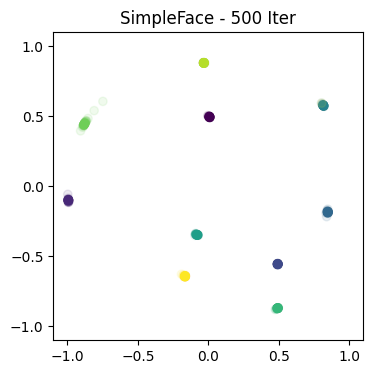

In [13]:
# plt.figure(figsize = (4,4))

# plt.title(f'SimpleFace - {N_STEPS} Iter')
# plt.scatter(Z[:,0], Z[:,1], c = dataset.targets, alpha = 0.1)
# plt.xlim(-1.1, 1.1)
# plt.ylim(-1.1, 1.1)
# plt.xticks([-1, -0.5, 0, 0.5, 1])
# plt.yticks([-1, -0.5, 0, 0.5, 1]);